In [33]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from random import shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# load data from a file and append it to the rawData
def parseReview(reviewLine):
    # Should return a triple of an integer, a string containing the review, and a string indicating the label
    return (reviewLine[0], reviewLine[2], reviewLine[3], reviewLine[4], reviewLine[5], reviewLine[6], reviewLine[7], reviewLine[8], 'fake' if reviewLine[1] == '__label1__' else 'real')

def loadData(path, Text=None):
    with open(path, encoding='utf8') as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader)
        for line in reader:
            (DOC_ID, RATING, VERIFIED_PURCHASE, PRODUCT_CATEGORY, PRODUCT_ID, PRODUCT_TITLE, REVIEW_TITLE, REVIEW_TEXT, LABEL) = parseReview(line)
            rawData.append((DOC_ID, RATING, VERIFIED_PURCHASE, PRODUCT_CATEGORY, PRODUCT_ID, PRODUCT_TITLE, REVIEW_TITLE, REVIEW_TEXT, LABEL))

In [19]:
rawData = []          # the filtered data from the dataset file (should be 21000 samples)

# references to the data files
reviewPath = 'amazon_reviews.txt'

## Do the actual stuff
# We parse the dataset and put it in a raw data list
print ("Preparing the dataset...")
loadData(reviewPath) 

Preparing the dataset...


In [20]:
columns = ["DOC_ID", "RATING", "VERIFIED_PURCHASE", "PRODUCT_CATEGORY", "PRODUCT_ID", "PRODUCT_TITLE", "REVIEW_TITLE", "REVIEW_TEXT", "LABEL"]

In [24]:
data = pd.DataFrame.from_records(rawData, columns=columns)

In [25]:
data.head()

,DOC_ID,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,LABEL
0,1,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",fake
1,2,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,fake
2,3,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,fake
3,4,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,fake
4,5,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,fake


In [26]:
data.groupby(data["LABEL"]).PRODUCT_CATEGORY.value_counts()

LABEL  PRODUCT_CATEGORY      
fake   Apparel                   350
       Automotive                350
       Baby                      350
       Beauty                    350
       Books                     350
       Camera                    350
       Electronics               350
       Furniture                 350
       Grocery                   350
       Health & Personal Care    350
       Home                      350
       Home Entertainment        350
       Home Improvement          350
       Jewelry                   350
       Kitchen                   350
       Lawn and Garden           350
       Luggage                   350
       Musical Instruments       350
       Office Products           350
       Outdoors                  350
       PC                        350
       Pet Products              350
       Shoes                     350
       Sports                    350
       Tools                     350
       Toys                      350
       V

In [27]:
data.groupby(data["LABEL"]).RATING.value_counts()

LABEL  RATING
fake   5         6059
       4         1999
       3          926
       1          889
       2          627
real   5         6151
       4         1974
       3          942
       1          868
       2          565
Name: RATING, dtype: int64

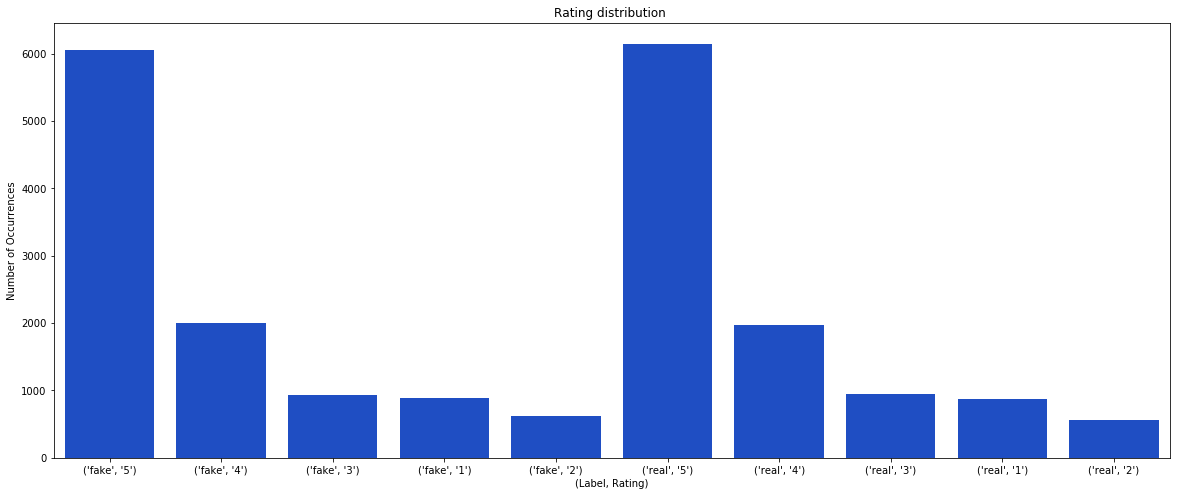

In [50]:
rating_dist = data.groupby(data["LABEL"]).RATING.value_counts()
plt.figure(figsize=(20,8))
sns.barplot(rating_dist.index, rating_dist.values, color=sns.xkcd_rgb["blue"])
plt.ylabel('Number of Occurrences')
plt.xlabel('(Label, Rating)')
plt.title('Rating distribution ')
plt.xticks(rotation='horizontal')
plt.show()

In [39]:
data.groupby("VERIFIED_PURCHASE").LABEL.value_counts()

VERIFIED_PURCHASE  LABEL
N                  fake     7623
                   real     1679
Y                  real     8821
                   fake     2877
Name: LABEL, dtype: int64

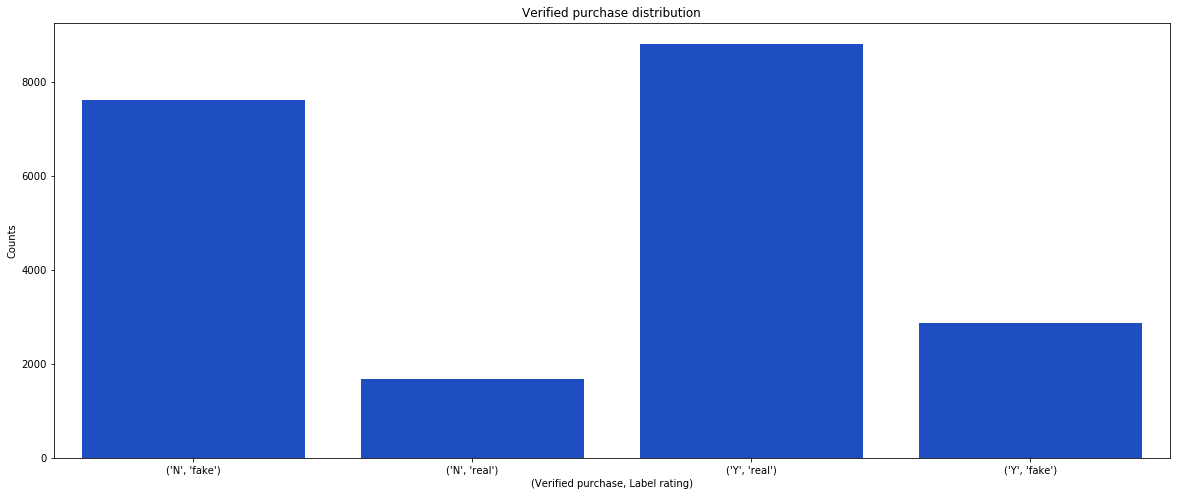

In [49]:
verified_purchase_dist = data.groupby(data["VERIFIED_PURCHASE"]).LABEL.value_counts()
plt.figure(figsize=(20,8))
sns.barplot(verified_purchase_dist.index, verified_purchase_dist.values, color=sns.xkcd_rgb["blue"])
plt.ylabel('Counts')
plt.xlabel('(Verified purchase, Label rating)')
plt.title('Verified purchase distribution')
plt.xticks(rotation='horizontal')
plt.show()

In [52]:
data["REVIEW_LEN"] = data["REVIEW_TEXT"].apply(len)
tot = sum(data["REVIEW_LEN"].values)
data.groupby(["LABEL"]).REVIEW_LEN.agg(lambda x: sum(x)/tot)

LABEL
fake    0.425097
real    0.574903
Name: REVIEW_LEN, dtype: float64

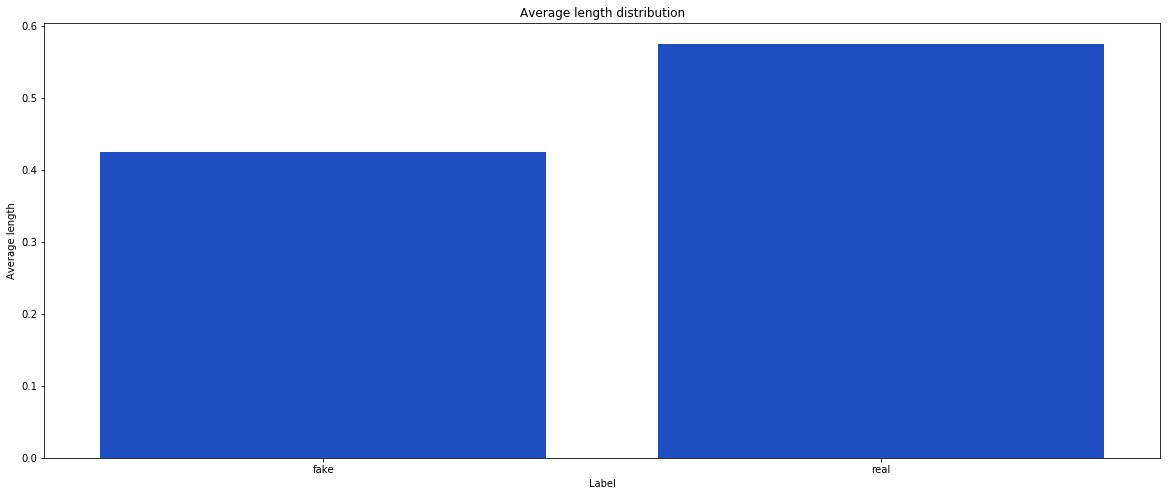

In [55]:
avg_len_distribution = data.groupby(["LABEL"]).REVIEW_LEN.agg(lambda x: sum(x)/tot)
plt.figure(figsize=(20,8))
sns.barplot(avg_len_distribution.index, avg_len_distribution.values, color=sns.xkcd_rgb["blue"])
plt.ylabel('Average length')
plt.xlabel('Label')
plt.title('Average length distribution')
plt.xticks(rotation='horizontal')
plt.show()

In [56]:
!pip install textstat

  Running setup.py bdist_wheel for textstat: started
  Running setup.py bdist_wheel for textstat: finished with status 'done'
  Stored in directory: C:\Users\Dhaval-PC\AppData\Local\pip\Cache\wheels\fb\b5\2f\3b2f0f64c6fe3ab7ec4ed5ee5b5735867ab7810d7a62d9f34d
Successfully built textstat


In [59]:
from textstat.textstat import textstat
data["FK_Score"] = data["REVIEW_TEXT"].apply(textstat.flesch_kincaid_grade)

In [68]:
data.groupby(["LABEL"]).FK_Score.agg(lambda x: sum(x)/len(x))

LABEL
fake    5.795600
real    5.848686
Name: FK_Score, dtype: float64

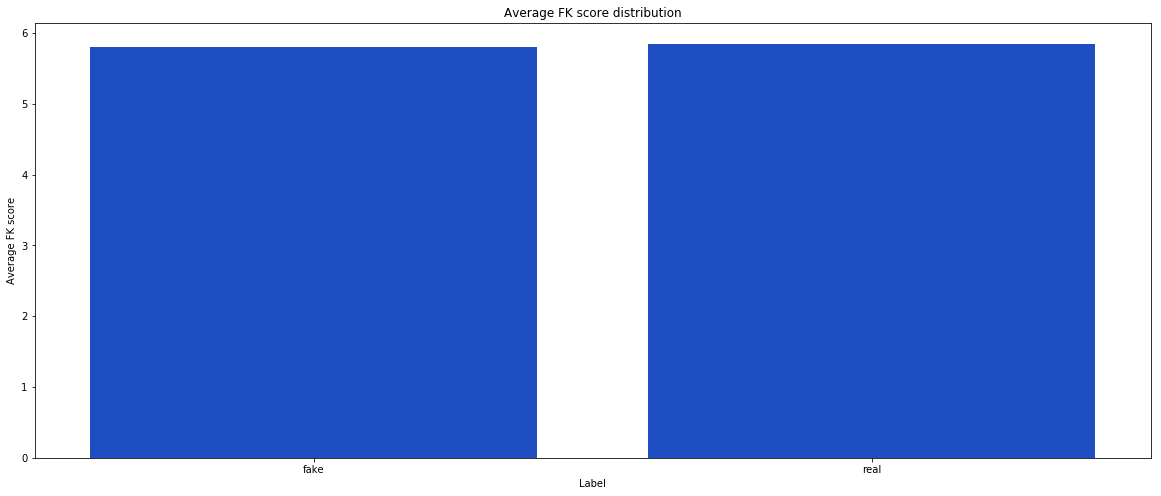

In [69]:
avg_FK_score_distribution = data.groupby(["LABEL"]).FK_Score.agg(lambda x: sum(x)/len(x))
plt.figure(figsize=(20,8))
sns.barplot(avg_FK_score_distribution.index, avg_FK_score_distribution.values, color=sns.xkcd_rgb["blue"])
plt.ylabel('Average FK score')
plt.xlabel('Label')
plt.title('Average FK score distribution')
plt.xticks(rotation='horizontal')
plt.show()

In [74]:
import nltk
stop_words = nltk.corpus.stopwords.words('english')
def stopCount(x):
    sum =0
    for char in x.split():
        sum+= char in stop_words
    return sum
data['stop_words_count'] = data['REVIEW_TEXT'].apply(stopCount)

In [75]:
data.groupby(["LABEL"]).stop_words_count.agg(lambda x: sum(x)/len(x))

LABEL
fake    24.696190
real    32.519048
Name: stop_words_count, dtype: float64

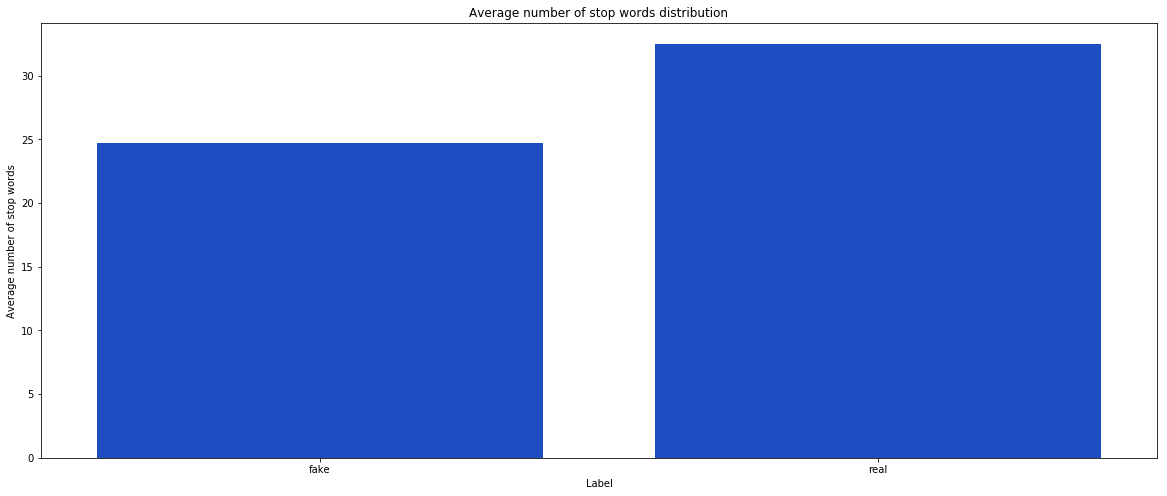

In [76]:
no_of_stop_words_distribution = data.groupby(["LABEL"]).stop_words_count.agg(lambda x: sum(x)/len(x))
plt.figure(figsize=(20,8))
sns.barplot(no_of_stop_words_distribution.index, no_of_stop_words_distribution.values, color=sns.xkcd_rgb["blue"])
plt.ylabel('Average number of stop words')
plt.xlabel('Label')
plt.title('Average number of stop words distribution')
plt.xticks(rotation='horizontal')
plt.show()

In [78]:
def capsCount(x):
    sum =0
    for char in x:
        sum+= char in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    return sum
data['CAP_COUNT'] = data['REVIEW_TEXT'].apply(capsCount)
data.groupby(["LABEL"]).CAP_COUNT.agg(lambda x: sum(x)/len(x))

LABEL
fake     8.712667
real    12.099810
Name: CAP_COUNT, dtype: float64

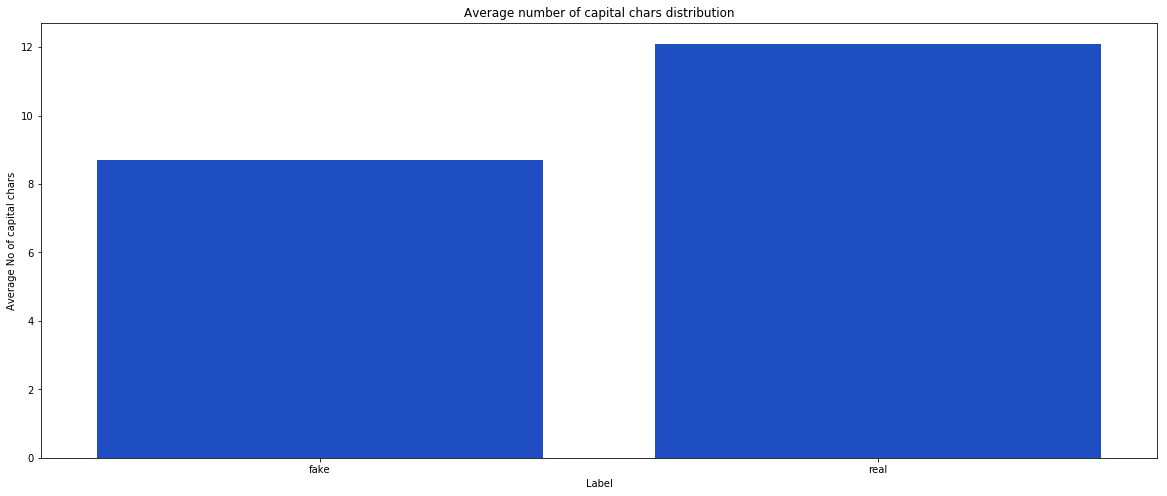

In [79]:
no_of_caps_distribution = data.groupby(["LABEL"]).CAP_COUNT.agg(lambda x: sum(x)/len(x))
plt.figure(figsize=(20,8))
sns.barplot(no_of_caps_distribution.index, no_of_caps_distribution.values, color=sns.xkcd_rgb["blue"])
plt.ylabel('Average No of capital chars')
plt.xlabel('Label')
plt.title('Average number of capital chars distribution')
plt.xticks(rotation='horizontal')
plt.show()

In [82]:
import string
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
def punctCount(x):
    return count(x, set(string.punctuation))
data['NO_OF_PUNCTUATION'] = data['REVIEW_TEXT'].apply(punctCount)
data.groupby(["LABEL"]).NO_OF_PUNCTUATION.agg(lambda x: sum(x)/len(x))

LABEL
fake    10.182571
real    15.571524
Name: NO_OF_PUNCTUATION, dtype: float64

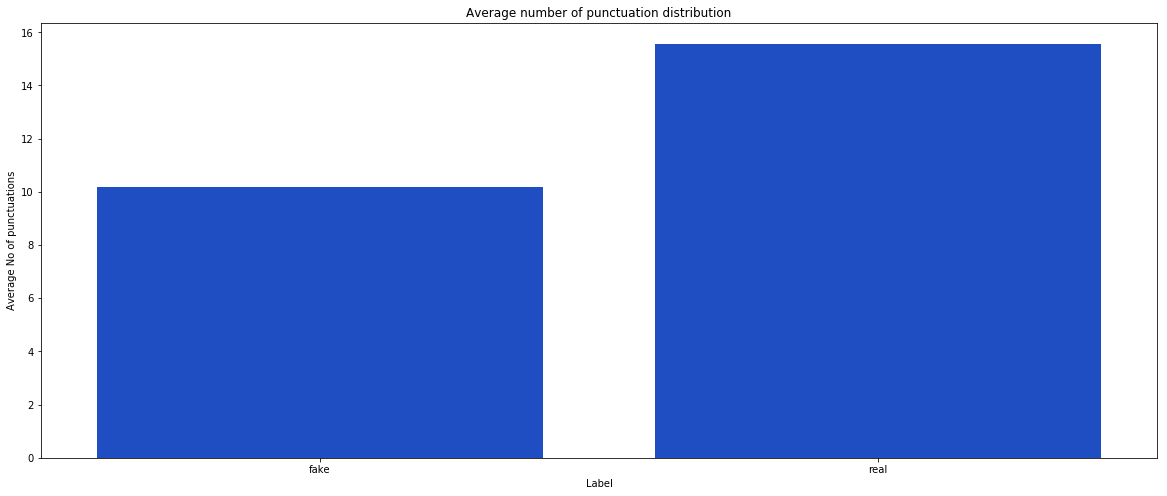

In [83]:
no_of_puncts_distribution = data.groupby(["LABEL"]).NO_OF_PUNCTUATION.agg(lambda x: sum(x)/len(x))
plt.figure(figsize=(20,8))
sns.barplot(no_of_puncts_distribution.index, no_of_puncts_distribution.values, color=sns.xkcd_rgb["blue"])
plt.ylabel('Average No of punctuations')
plt.xlabel('Label')
plt.title('Average number of punctuation distribution')
plt.xticks(rotation='horizontal')
plt.show()

In [86]:
import re
import string
match_list = []

def checkName(title,text):
    matches = []
    for word in title.split():
        word = "".join((char for char in word if char not in string.punctuation))
        #print(word)
        myreg = r'\b'+word+r'\b'
        r = re.compile(myreg, flags=re.I | re.X)
        matches.append(r.findall(text))
    return len(matches)
        
for a,b in zip(data.PRODUCT_TITLE, data.REVIEW_TEXT):
    number_of_matches = checkName(a,b)
    match_list.append(number_of_matches)
    
data["MATCH_DF"] = match_list

In [87]:
data.groupby(["LABEL"]).MATCH_DF.agg(lambda x: sum(x)/len(x))

LABEL
fake    13.823143
real    10.570667
Name: MATCH_DF, dtype: float64

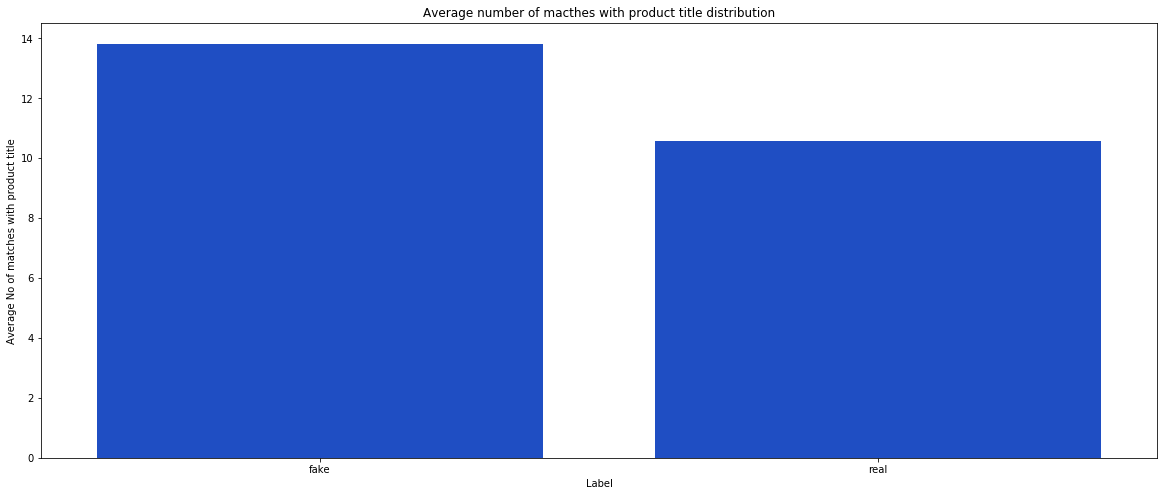

In [88]:
no_of_matches_distribution = data.groupby(["LABEL"]).MATCH_DF.agg(lambda x: sum(x)/len(x))
plt.figure(figsize=(20,8))
sns.barplot(no_of_matches_distribution.index, no_of_matches_distribution.values, color=sns.xkcd_rgb["blue"])
plt.ylabel('Average No of matches with product title')
plt.xlabel('Label')
plt.title('Average number of macthes with product title distribution')
plt.xticks(rotation='horizontal')
plt.show()

In [91]:
data.dtypes

DOC_ID                object
RATING                object
VERIFIED_PURCHASE     object
PRODUCT_CATEGORY      object
PRODUCT_ID            object
PRODUCT_TITLE         object
REVIEW_TITLE          object
REVIEW_TEXT           object
LABEL                 object
REVIEW_LEN             int64
FK_Score             float64
stop_words_count       int64
CAP_COUNT              int64
NO_OF_PUNCTUATION      int64
matchesDf              int64
MATCH_DF               int64
dtype: object

In [95]:
def convert_to_label(x):
    if(x == '1' or x == '2'):
        return 'negative'
    else:
        if (x == '4' or x == '5'):
            return 'positive'
        else: 
            return np.nan

In [96]:
data["sentiment"] = data['RATING'].apply(convert_to_label)
data = data.dropna()
data.sentiment.value_counts()

In [100]:
data_pos = data[data['sentiment']=='positive'].sample(frac=0.2)
data_neg = data[data['sentiment']=='negative']
df = pd.concat([data_pos, data_neg], ignore_index=True)

In [124]:
rawData = df[["REVIEW_TEXT", "sentiment"]]
rawData = [tuple(x) for x in rawData.values]

In [126]:
rawData[0]

('I have had this for about a month and love it....I am still learning all of the features but I have to say that this is the best camera I have owned. The images are very clear and bright,  zoom is fast and so is shutter time. I also like the pet photo function.',
 'positive')

In [127]:
def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(C=0.01))])
    return SklearnClassifier(pipeline).train(trainData)

In [128]:
import nltk.stem
english_lemmantizer = nltk.stem.WordNetLemmatizer()
def preProcess(text):
    # Should return a list of tokens
    lemmantized_list = [english_lemmantizer.lemmatize(word) for word in text.split(" ")]
    return [" ".join(words) for words in nltk.bigrams(lemmantized_list)] + [" ".join(words) for words in nltk.trigrams(lemmantized_list)] + lemmantized_list

In [129]:
# PREDICTING LABELS GIVEN A CLASSIFIER
def predictLabels(reviewSamples, classifier):
    #return classifier.classify_many(map(lambda t: toFeatureVector(preProcess(t[1])), reviewSamples))
    return classifier.classify_many(map(lambda t: t[0], reviewSamples))

def predictLabel(reviewSample, classifier):
    return classifier.classify(toFeatureVector(preProcess(reviewSample)))

In [130]:
def crossValidate(dataset, folds):
    shuffle(dataset)
    cv_results = []
    results = []
    foldSize = int(len(dataset)/folds)
    for i in range(0,len(dataset),foldSize):
        #print("current fold %f", i+1)
        trainData = dataset[0:i] + dataset[i + foldSize:len(dataset)]
        classifier = trainClassifier(trainData)
        predictions = predictLabels(dataset[i:i+foldSize], classifier)
        true_labels = list(map(lambda d: d[1], dataset[i:i+foldSize]))
        a = accuracy_score(true_labels, predictions)
        p, r, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
        results.append((p, r, f1, a))
    #return cv_results
    cv_results = np.mean(np.array(results), axis=0)
    return cv_results

In [131]:
def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(trainData)

In [138]:
featureDict = {}
def toFeatureVector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    localDict = {}
    for token in tokens:
        if token not in localDict:
            localDict[token] = 1
        else:
            localDict[token] += 1
            
        if token not in featureDict:
            featureDict[token] = 1
        else:
            featureDict[token] += 1
    
    return localDict

In [139]:
def splitData(percentage):
    dataSamples = len(rawData)
    halfOfData = int(len(rawData)/2)
    trainingSamples = int((percentage*dataSamples)/2)
    for (Text, Label) in rawData[:trainingSamples] + rawData[halfOfData:halfOfData+trainingSamples]:
        trainData.append((toFeatureVector(preProcess(Text)),Label))
    for (Text, Label) in rawData[trainingSamples:halfOfData] + rawData[halfOfData+trainingSamples:]:
        testData.append((toFeatureVector(preProcess(Text)),Label))

In [140]:
trainData = []        # the training data as a percentage of the total dataset (currently 80%, or 16800 samples)
testData = []         # the test data as a percentage of the total dataset (currently 20%, or 4200 samples)

print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Preparing training and test data...",sep='\n')
splitData(0.8)
# We print the number of training samples and the number of features
print("Now %d rawData, %d trainData, %d testData" % (len(rawData), len(trainData), len(testData)),
      "Training Samples: ", len(trainData), "Features: ", len(featureDict), sep='\n')
print("Results after cross-validations: ", crossValidate(trainData, 10))

Now 6186 rawData, 0 trainData, 0 testData
Preparing training and test data...
Now 6186 rawData, 4948 trainData, 1238 testData
Training Samples: 
4948
Features: 
576768
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Training Classifier...
Results after cross-validations:  [0.83692277 0.83691262 0.83673429 0.84495767]


In [141]:
print(len(trainData))
classifier = trainClassifier(trainData)
predictions = predictLabels(testData, classifier)
true_labels = list(map(lambda d: d[1], testData))
a = accuracy_score(true_labels, predictions)
p, r, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
print("Precision: ", p)
print("Recall: ", a)
print("f1-score: ", f1)
print("accuracy: ", a)

4948
Training Classifier...
Precision:  0.8505736626717334
Recall:  0.8505654281098546
f1-score:  0.8505645505942381
accuracy:  0.8505654281098546
